# Welcome!

This is going to be a random exploration of well data, mainly focusing on viz! Last year's talk would be a great intro into this talk. I won't go into as much detail into dataframe stuff, but will dive deeper into viz!

In [1]:
import pandas as pd
import numpy as np
import datetime

from glob import glob

In [2]:
cd drive/My Drive/T21_well_bonanza

/content/drive/My Drive/T21_well_bonanza


# prepping data input

Let's use glob to collect all of the excel files we would like to load in. The * before the .xls will grab every excel file in the folder. Use with caution! 

In [3]:
excel_files = glob("ca_geothermal_data/*.xls")
excel_files

['ca_geothermal_data/casad.xls',
 'ca_geothermal_data/coso.xls',
 'ca_geothermal_data/geysers.xls',
 'ca_geothermal_data/heber.xls',
 'ca_geothermal_data/saltons.xls']

In [4]:
df_prod = pd.DataFrame() # making a 

print('Geothermal Fields:')
for z in range(len(excel_files)):
  field = excel_files[z].replace('ca_geothermal_data/','').split('.xls')[0]
  print(field)
  if field == 'casad' :
    df_ = pd.read_excel(excel_files[z], skiprows=5, usecols=[1,2,3,4])
  else :
    df_ = pd.read_excel(excel_files[z], skiprows=6, usecols=[1,2,3,4])

  df_.columns = df_.columns.str.replace(' ', '') #

  if field == 'geysers' :
    df_.rename(columns={'Production(kilogramstimes1,000)': 'prod_MT', 
                       'Injection(kilogramstimes1,000)': 'injection_MT'}, inplace=True)
  else :
    df_.rename(columns={'Water(kilogramstimes1,000)': 'prod_MT', 
                       'Injection(kilogramstimes1,000)': 'injection_MT'}, inplace=True)
  
  df_.rename(columns={'Year': 'year', 
                      'Month': 'month'}, inplace=True)

  df_.replace('*', np.nan, inplace=True)
  df_ = df_.dropna(thresh=3)
  df_['field_name'] = field
  df_prod = df_prod.append(df_)

Geothermal Fields:
casad
coso
geysers
heber
saltons


The field names will need to be fixed, but good enough for now! Below is a map of the locations. 

<br>
<img src='https://drive.google.com/uc?id=17ccEKnfxE6MpDqITm_qdMMiQBijIJhBN'>

### QC'ing the data frame

In [5]:
df_prod.describe()

,year,month,prod_MT,injection_MT
count,2382.000000,2373.000000,2.382000e+03,2.371000e+03
mean,2000.042401,6.500211,4.363629e+06,3.182639e+06
std,12.559823,3.449787,2.832174e+06,2.437544e+06
min,1960.000000,1.000000,0.000000e+00,0.000000e+00
25%,1991.000000,4.000000,2.054466e+06,1.367841e+06
50%,2001.000000,7.000000,4.082838e+06,2.121199e+06
75%,2011.000000,9.000000,6.055216e+06,5.021998e+06
max,2021.000000,12.000000,1.267996e+07,1.020871e+07


Glad that the max month is 12, the years also make sense. 

In [6]:
df_prod.month.unique()

array([ 7.,  8.,  9., 10., 11., 12.,  1.,  2.,  3.,  4.,  5.,  6., nan])

Checking out the months in the dataset .... we will have to fix that nan later. Geysers production was only tracked yearly early in it's life.

# cleaned data frame!

In [7]:
df_prod

,year,month,prod_MT,injection_MT,field_name
1,1984.0,7.0,2093.0,2077.0,casad
2,1984.0,8.0,715.0,715.0,casad
3,1984.0,9.0,17326.0,18084.0,casad
4,1984.0,10.0,52951.0,52951.0,casad
5,1984.0,11.0,1185043.0,894397.0,casad
...,...,...,...,...,...
461,2020.0,5.0,6258603.0,5446471.0,saltons
462,2020.0,6.0,11185769.0,9239716.0,saltons
463,2020.0,7.0,12045690.0,10050834.0,saltons
464,2020.0,8.0,11526198.0,9689633.0,saltons


### Creating a new columns

One thing I like to do 

In [8]:
df_prod['pro_minus_injection'] = df_prod.prod_MT.values - df_prod.injection_MT.values

Making a column of zero's for future datetime issues.

In [9]:
df_prod['day'] = 1

In [10]:
df_prod.describe()

,year,month,prod_MT,injection_MT,pro_minus_injection,day
count,2382.000000,2373.000000,2.382000e+03,2.371000e+03,2.371000e+03,2382.0
mean,2000.042401,6.500211,4.363629e+06,3.182639e+06,1.201226e+06,1.0
std,12.559823,3.449787,2.832174e+06,2.437544e+06,1.497463e+06,0.0
min,1960.000000,1.000000,0.000000e+00,0.000000e+00,-1.682461e+06,1.0
25%,1991.000000,4.000000,2.054466e+06,1.367841e+06,9.224900e+04,1.0
50%,2001.000000,7.000000,4.082838e+06,2.121199e+06,7.955160e+05,1.0
75%,2011.000000,9.000000,6.055216e+06,5.021998e+06,1.779935e+06,1.0
max,2021.000000,12.000000,1.267996e+07,1.020871e+07,8.134885e+06,1.0


# matplotlib

Let's do a few plots in matplotlib. Matplotlib is a great package for scientific plotting, that is ultimately changeable. 

In [11]:
import matplotlib.pyplot as plt

### histograms

This is a standard output of matplotlib histogram function. All it needs is an array. 

(array([ 28., 795., 612., 566., 166.,  76.,  37.,  53.,  23.,  15.]),
 array([-1682461. ,  -700726.4,   281008.2,  1262742.8,  2244477.4,
         3226212. ,  4207946.6,  5189681.2,  6171415.8,  7153150.4,
         8134885. ]),
 <a list of 10 Patch objects>)

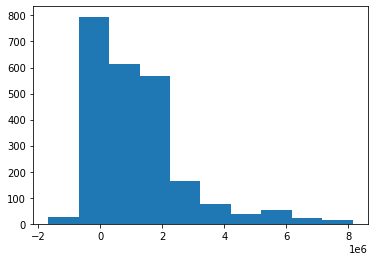

In [12]:
plt.hist(df_prod.pro_minus_injection.values)

Nice! Let's add our widigets for the individual production and injection data. 

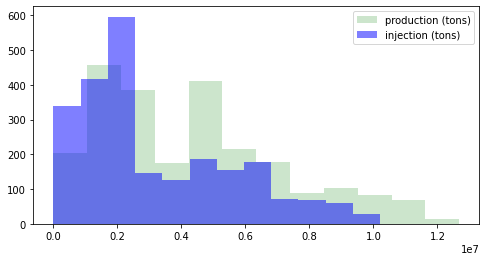

In [13]:
plt.figure(figsize=(8,4))
plt.hist(df_prod.prod_MT.values, bins=12, color='green', alpha=0.2, label='production (tons)')
plt.hist(df_prod.injection_MT.values, bins=12, color='blue', alpha=0.5, label='injection (tons)')
plt.legend()

To unpack what we did:


*   set the number of bins (bins=12)
*   specified color
*   added a legend
*   set opacity using alpha
*   set figure size



Looking at this from a subsurface perspective for these 5 power plant complexes, there are some 'missing' subsurface mass.

### line plot

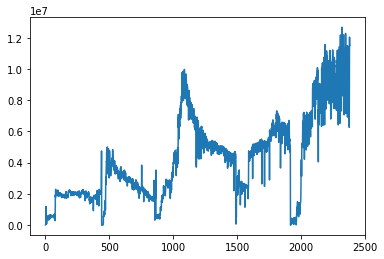

In [14]:
plt.plot(df_prod.prod_MT.values)

This plot does not really make sense, as the x index is just the index count. Let's look at 1 power plant. But it does point out you don't need to specify an x axis with plt.plot.

In [15]:
salton = df_prod[df_prod['field_name'] == 'saltons']

In [16]:
salton

,year,month,prod_MT,injection_MT,field_name,pro_minus_injection,day
1,1982.0,1.0,0.0,NaN,saltons,NaN,1
2,1982.0,2.0,23102.0,22711.0,saltons,391.0,1
3,1982.0,3.0,31557.0,30261.0,saltons,1296.0,1
4,1982.0,4.0,3908.0,2829.0,saltons,1079.0,1
5,1982.0,5.0,21273.0,19565.0,saltons,1708.0,1
...,...,...,...,...,...,...,...
461,2020.0,5.0,6258603.0,5446471.0,saltons,812132.0,1
462,2020.0,6.0,11185769.0,9239716.0,saltons,1946053.0,1
463,2020.0,7.0,12045690.0,10050834.0,saltons,1994856.0,1
464,2020.0,8.0,11526198.0,9689633.0,saltons,1836565.0,1


Let's make the date something senseable. Pandas handles dates pretty well once you get a hang of it. 

In [17]:
foo = salton[['year', 'month', 'day']].astype('int64')
salton['date'] = pd.to_datetime(foo)

salton.dtypes # note the dtypes

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


year                          float64
month                         float64
prod_MT                       float64
injection_MT                  float64
field_name                     object
pro_minus_injection           float64
day                             int64
date                   datetime64[ns]
dtype: object

Let's drop row 1 since it does not have production or injection data.

In [18]:
salton = salton.drop(1)

In [19]:
salton.head(3)

,year,month,prod_MT,injection_MT,field_name,pro_minus_injection,day,date
2,1982.0,2.0,23102.0,22711.0,saltons,391.0,1,1982-02-01
3,1982.0,3.0,31557.0,30261.0,saltons,1296.0,1,1982-03-01
4,1982.0,4.0,3908.0,2829.0,saltons,1079.0,1,1982-04-01


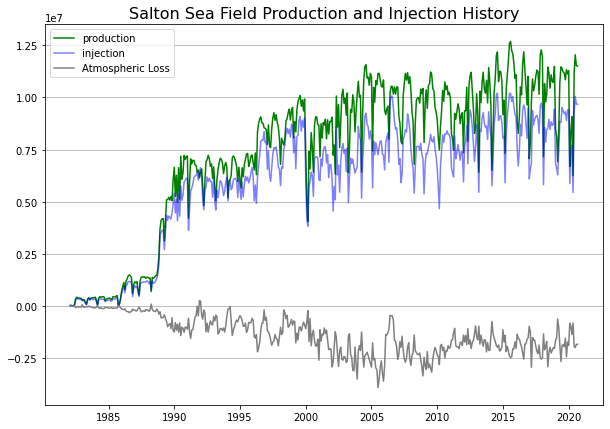

In [20]:
plt.figure(figsize=(10,7))
plt.title('Salton Sea Field Production and Injection History', size=16)
plt.plot(salton.date, salton.prod_MT, color='green', label='production')
plt.plot(salton.date, salton.injection_MT, color='blue', alpha=0.5, label='injection')

plt.plot(salton.date, -1*salton.pro_minus_injection, color='grey', label='Atmospheric Loss')
plt.legend()
plt.grid(axis='y')

This looks oddly seasonal, lets dive into a subset.

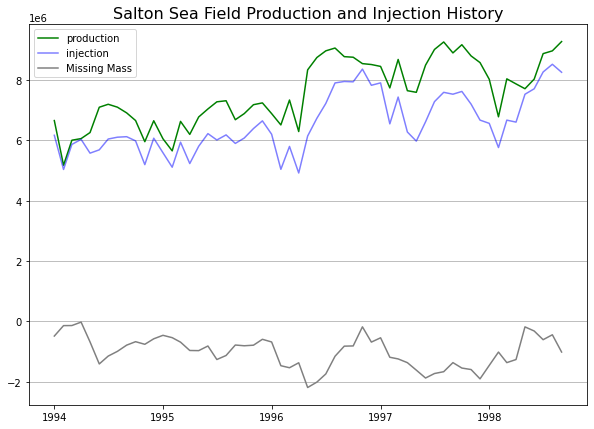

In [21]:
plt.figure(figsize=(10,7))
plt.title('Salton Sea Field Production and Injection History', size=16)
plt.plot(salton.date[143:200], salton.prod_MT[143:200], color='green', label='production')
plt.plot(salton.date[143:200], salton.injection_MT[143:200], color='blue', alpha=0.5, label='injection')

plt.plot(salton.date[143:200], -1*salton.pro_minus_injection[143:200], color='grey', label='Missing Mass')
plt.legend()
plt.grid(axis='y')

Looks like maintance around winter. Might coinside with lowest energy use in the state due to more AC use than heating in California. Neat.

### scatter

Same theme, let's dive into the seasonality using scatter plots.

Text(0.5, 0, 'Months')

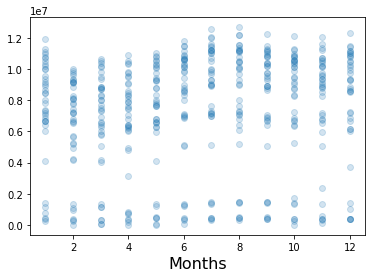

In [22]:
plt.scatter(salton.month, salton.prod_MT, alpha=0.2)
plt.xlabel('Months', size=16)

The first few years had low-ish production as it was ramping up. Let's just plot from 

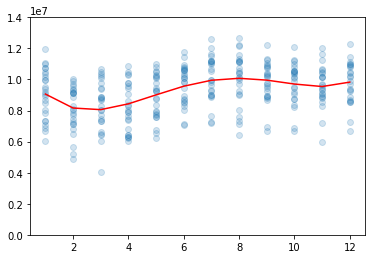

In [23]:
x = salton.month[143:440]
y = salton.prod_MT[143:440]
z = salton.injection_MT[143:440]

plt.scatter(x, y, alpha=0.2)
plt.ylim([-1e2, 1.4e7])
plt.plot(np.unique(x), np.poly1d(np.polyfit(x, y, 5))(np.unique(x)), color='r')

Looks like Feb-March is the lowest. a 5th order curve is probably a bit much. Feel free to play around with the polyfit!

### bar chart

Let's use the same variable as above, but as a bar chart.

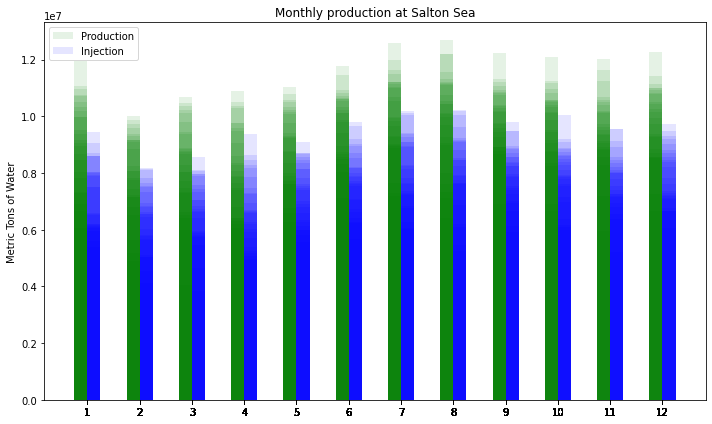

In [24]:

width = 0.25

fig, ax = plt.subplots(figsize=(10,6))
rects1 = ax.bar(x - width/2, y, width, color = 'green', alpha=0.1, label='Production')
rects2 = ax.bar(x + width/2, z, width, color = 'blue', alpha=0.1, label='Injection')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Metric Tons of Water')
ax.set_title('Monthly production at Salton Sea')
ax.set_xticks(x)
ax.legend()

fig.tight_layout()

plt.show()

While this does communcate some of the yearly variablity, does not do a great job.

# seaborn

### violin plot

In [25]:
import seaborn as sns

Let's do a violin plot!

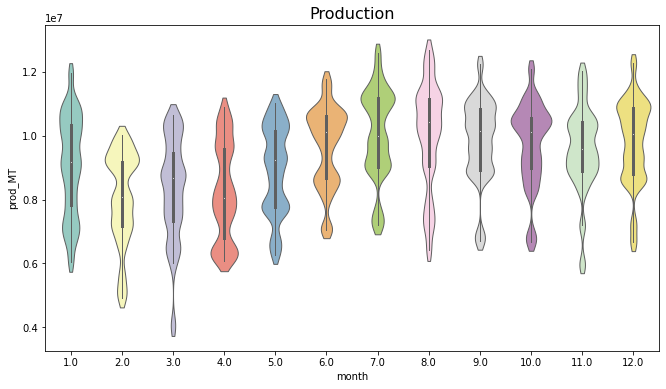

In [26]:
f, ax = plt.subplots(figsize=(11, 6))

plt.title('Production', size = 16)
sns.violinplot(x=x, y=y, palette="Set3", bw=.2, cut=1, linewidth=1)

Using a violin plot, it's easier to see the long tails, and that most of the data is pretty consistent. 

### line plot

In [27]:
salton

,year,month,prod_MT,injection_MT,field_name,pro_minus_injection,day,date
2,1982.0,2.0,23102.0,22711.0,saltons,391.0,1,1982-02-01
3,1982.0,3.0,31557.0,30261.0,saltons,1296.0,1,1982-03-01
4,1982.0,4.0,3908.0,2829.0,saltons,1079.0,1,1982-04-01
5,1982.0,5.0,21273.0,19565.0,saltons,1708.0,1,1982-05-01
6,1982.0,6.0,45043.0,42210.0,saltons,2833.0,1,1982-06-01
...,...,...,...,...,...,...,...,...
461,2020.0,5.0,6258603.0,5446471.0,saltons,812132.0,1,2020-05-01
462,2020.0,6.0,11185769.0,9239716.0,saltons,1946053.0,1,2020-06-01
463,2020.0,7.0,12045690.0,10050834.0,saltons,1994856.0,1,2020-07-01
464,2020.0,8.0,11526198.0,9689633.0,saltons,1836565.0,1,2020-08-01


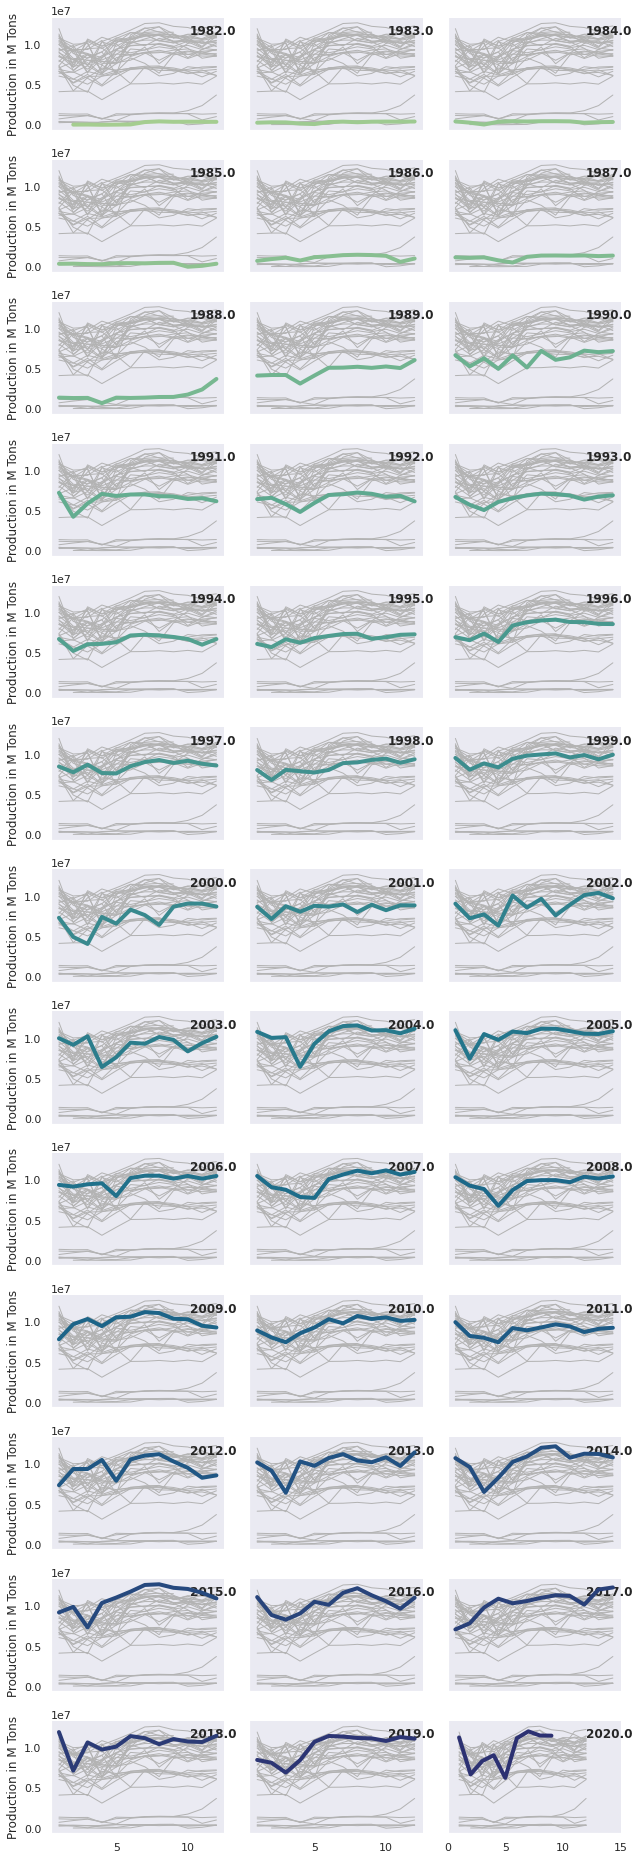

In [28]:
sns.set_theme(style="dark")

# Plot each year's time series in its own facet
g = sns.relplot(
    data=salton,
    x="month", y="prod_MT", col="year", hue="year",
    kind="line", palette="crest", linewidth=4, zorder=5,
    col_wrap=3, height=2, aspect=1.5, legend=False,
)

# Iterate over each subplot to customize further
for year, ax in g.axes_dict.items():

    # Add the title as an annotation within the plot
    ax.text(.8, .85, year, transform=ax.transAxes, fontweight="bold")

    # Plot every year's time series in the background
    sns.lineplot(
        data=salton, x="month", y="prod_MT", units="year",
        estimator=None, color=".7", linewidth=1, ax=ax,
    )

# Reduce the frequency of the x axis ticks
ax.set_xticks(ax.get_xticks()[::2])

# Tweak the supporting aspects of the plot
g.set_titles("")
g.set_axis_labels("", "Production in M Tons")
g.tight_layout()

.... don't know why the last plot has ~15 months. 

### scatter

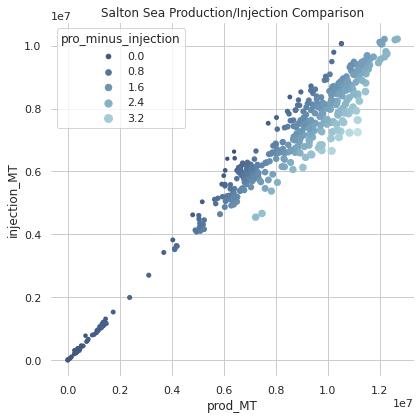

In [29]:
sns.set_theme(style="whitegrid")

# Load the example diamonds dataset

f, ax = plt.subplots(figsize=(6.5, 6.5))

plt.title('Salton Sea Production/Injection Comparison')
sns.despine(f, left=True, bottom=True)

sns.scatterplot(x=salton.prod_MT, 
                y=salton.injection_MT,
                hue=salton.pro_minus_injection*10000, 
                size=salton.pro_minus_injection*10000,
                palette="ch:r=-.2,d=.3_r", 
                linewidth=0, 
                ax=ax)

### scatterplot matrix

Let's make a new, smaller dataframe of our entire dataset.

In [30]:
df_scatter = df_prod[['prod_MT', 'injection_MT', 'field_name']]
df_scatter

,prod_MT,injection_MT,field_name
1,2093.0,2077.0,casad
2,715.0,715.0,casad
3,17326.0,18084.0,casad
4,52951.0,52951.0,casad
5,1185043.0,894397.0,casad
...,...,...,...
461,6258603.0,5446471.0,saltons
462,11185769.0,9239716.0,saltons
463,12045690.0,10050834.0,saltons
464,11526198.0,9689633.0,saltons


<Figure size 648x648 with 0 Axes>

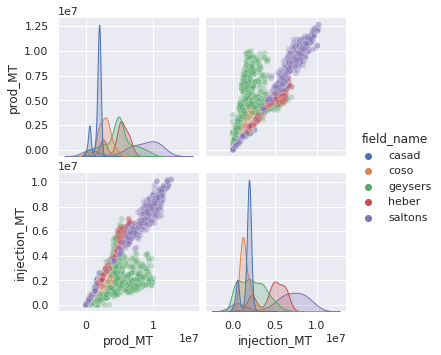

In [31]:
plt.figure(figsize=(9,9))
sns.set_theme(style="darkgrid")


sns.pairplot(df_scatter,
             hue='field_name',
             plot_kws={'alpha':0.3})

The production to injection should roughly be 1 to 1, to maintain subsurface mass balace. Check out Geysers!

# plotly express

plotly express is a wrapper for plotly, which makes syntax a bit easier to handle. 

In [32]:
import plotly.graph_objs as go
import plotly.express as px

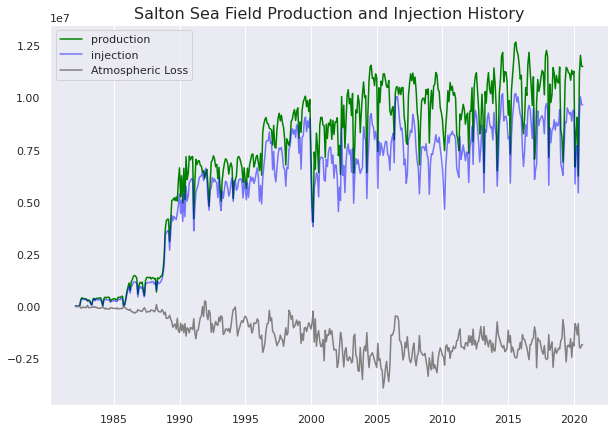

In [33]:
plt.figure(figsize=(10,7))
plt.title('Salton Sea Field Production and Injection History', size=16)
plt.plot(salton.date, salton.prod_MT, color='green', label='production')
plt.plot(salton.date, salton.injection_MT, color='blue', alpha=0.5, label='injection')

plt.plot(salton.date, -1*salton.pro_minus_injection, color='grey', label='Atmospheric Loss')
plt.legend()
plt.grid(axis='y')

In [34]:


# Plotly figure 1
fig = px.line(salton, x='date', y='prod_MT',
              hover_name='prod_MT')

fig.update_traces(line_color='#456987')
fig.update_layout(title='Production & Injection' , showlegend=True)

# Plotly figure 2
fig2 = go.Figure(fig.add_traces(
                 data=px.line(salton, x='date', y='injection_MT',
                              hover_name="injection_MT")._data))
fig2.update_layout(title='Production & Injection' , showlegend=True)

fig2.show()